In [277]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.constants import DATASETS_FOLDER_PATH
from Utils.data_utils import load_preprocessed_data_from_folder

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

# Courses Packages
from Utils.DataVisualization import PlotConfusionMatrix, PlotLabelsHistogram, PlotBinaryClassData

# Model
from sklearn.naive_bayes import GaussianNB


# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

# Separate features (X) and labels (y) from the loaded data
mX = data.drop(columns=["Potability"])  # Exclude the label column if it's included in the data
vY = data["Potability"]  # Extract the label column

# Now you can use X and y for further training

In [278]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000,3996.000000
mean,0.505311,0.539229,0.356850,0.530729,0.581404,0.427316,0.462487,0.533157,0.475886,0.500000
std,0.102383,0.117732,0.142762,0.122167,0.107484,0.139168,0.125155,0.126553,0.144599,0.500063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.445069,0.469368,0.254508,0.454815,0.521145,0.324846,0.378726,0.454280,0.378779,0.000000
50%,0.503327,0.540575,0.339079,0.531114,0.581081,0.420330,0.458965,0.534191,0.472306,0.500000
75%,0.564544,0.611621,0.443330,0.606549,0.642954,0.523981,0.547767,0.616287,0.574892,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [279]:
# Parameters

# Data
numSamplesRatio = 0.2

mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = numSamplesRatio, shuffle = True, stratify = vY)

In [280]:
# Train Test Split

print(f'The training features data shape: {mXTrain.shape}')
print(f'The training labels data shape: {vYTrain.shape}')
print(f'The test features data shape: {mXTest.shape}')
print(f'The test labels data shape: {vYTest.shape}')
print(f'The unique values of the labels: {np.unique(vY)}')

The training features data shape: (3196, 9)
The training labels data shape: (3196,)
The test features data shape: (800, 9)
The test labels data shape: (800,)
The unique values of the labels: [0. 1.]


## Classifier Model

Gaussian Naive Bayes  
   Models each **independent** feature by $P \left( {x}_{i} \mid y \right) = \frac{1}{\sqrt{2 \pi {\sigma}_{y}^{2}}} \exp \left( -\frac{{\left( {x}_{i} - {\mu}_{y} \right)}^{2}}{2 {\sigma}_{y}^{2}}\right)$.  

In [281]:
# Gaussian NB Classifier Model
oGausNBcls = GaussianNB()
oGausNBcls = oGausNBcls.fit(mXTrain, vYTrain)

Accuracy  = 56.63%
Precision = 58.12%
Recall    = 47.50%
F1 Score  = 52.27%


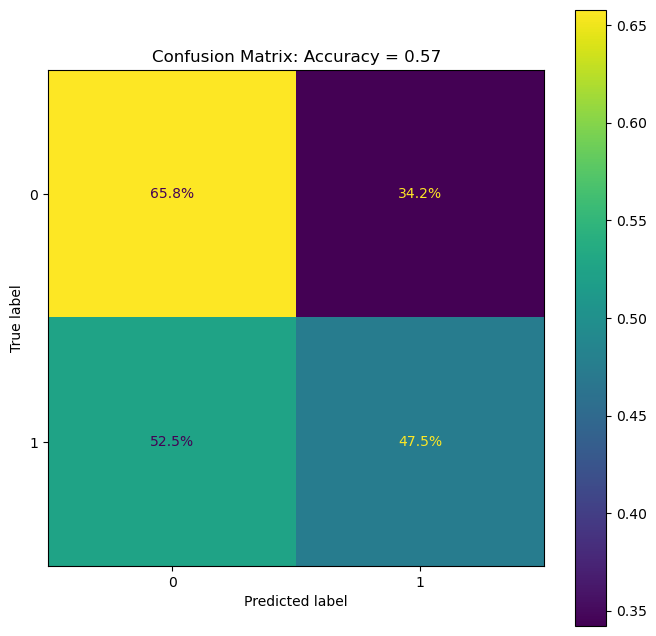

In [282]:
# Performance Train Data

vHatY = oGausNBcls.predict(mXTrain)
vYGt  = vYTrain

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
train_data_scores_non_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'Accuracy': valAcc}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

Accuracy  = 57.50%
Precision = 58.67%
Recall    = 50.75%
F1 Score  = 54.42%


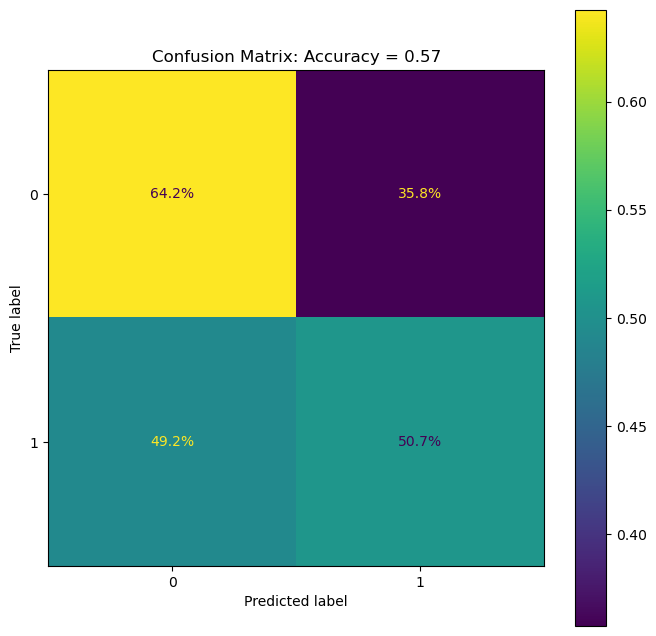

In [283]:
# Performance Test Data

vHatY = oGausNBcls.predict(mXTest)
vYGt  = vYTest

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
test_data_scores_non_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'Accuracy': valAcc}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

## Probability calibration

In [284]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Use the calibrated classifier to predict probabilities on the test data
prob_pos = oGausNBcls.predict_proba(mXTest)[:, 1]

# Compute true and predicted probabilities for the positive class
true_prob_non_calibrated, pred_prob_non_calibrated = calibration_curve(vYTest, prob_pos, n_bins=10)

In [285]:
from sklearn.calibration import CalibratedClassifierCV

# Create CalibratedClassifierCV with isotonic calibration
calibrated_classifier = CalibratedClassifierCV(oGausNBcls, method='isotonic', cv='prefit')

# Fit the calibrated classifier to your training data
calibrated_classifier.fit(mXTrain, vYTrain)

# Make predictions on your test data
y_pred = calibrated_classifier.predict(mXTest)

Accuracy  = 56.73%
Precision = 58.11%
Recall    = 48.19%
F1 Score  = 52.69%


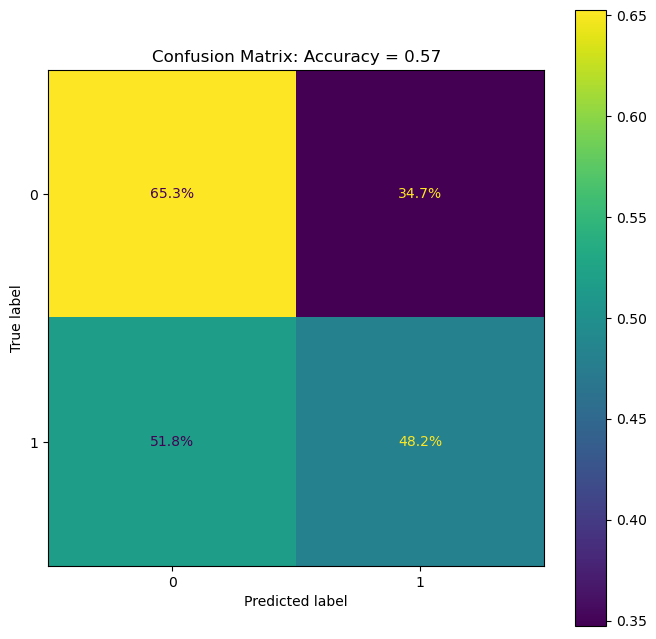

In [286]:
# Performance Train Data

vHatY = calibrated_classifier.predict(mXTrain)
vYGt  = vYTrain

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
train_data_scores_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'Accuracy': valAcc}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

Accuracy  = 57.38%
Precision = 58.50%
Recall    = 50.75%
F1 Score  = 54.35%


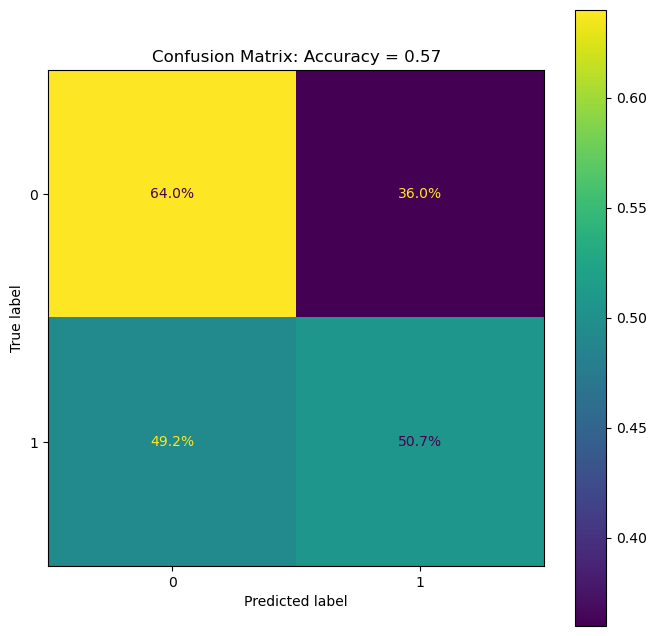

In [287]:
# Performance Test Data

vHatY = calibrated_classifier.predict(mXTest)
vYGt  = vYTest

valAcc = np.mean(vHatY == vYGt)
valPrecision, valRecall, valF1, _ = precision_recall_fscore_support(vYGt, vHatY, pos_label = 1, average = 'binary')

# Create a single list containing values from all variables
test_data_scores_calibrated = [valAcc, valPrecision, valRecall, valF1]

print(f'Accuracy  = {valAcc:0.2%}')
print(f'Precision = {valPrecision:0.2%}')
print(f'Recall    = {valRecall:0.2%}'   )
print(f'F1 Score  = {valF1:0.2%}'       )

dScore = {'Accuracy': valAcc}

hF, hA = plt.subplots(figsize = (8, 8))
PlotConfusionMatrix(vYGt, vHatY, normMethod = 'true', hA = hA, dScore = dScore, valFormat = '0.1%') #<! The accuracy should be >= than above!
plt.show()

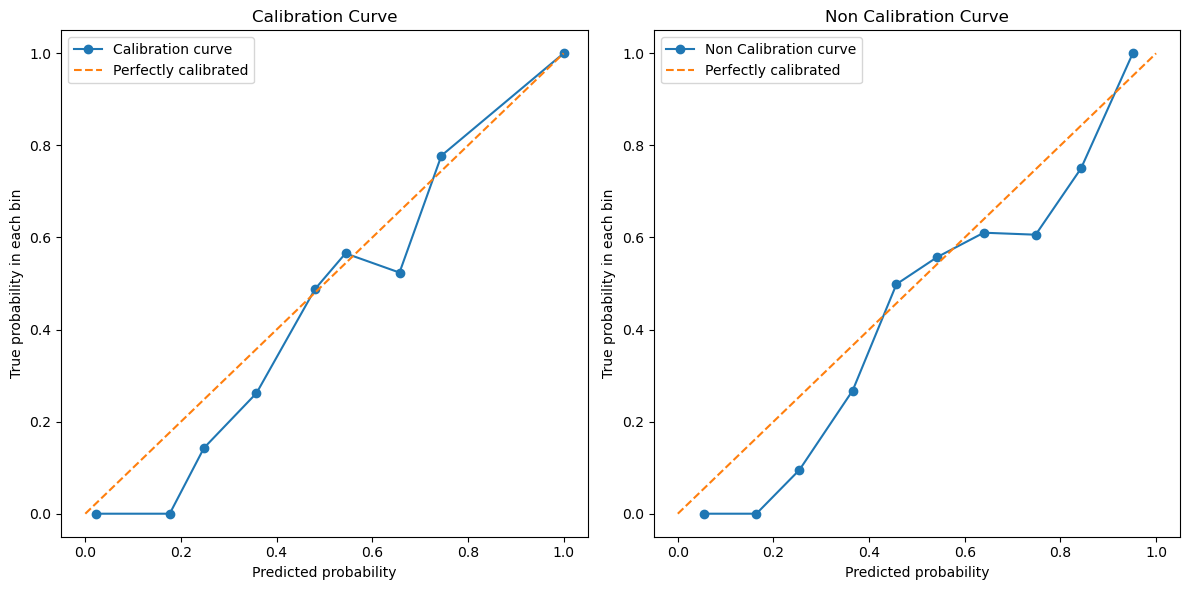

In [288]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Use the calibrated classifier to predict probabilities on the test data
prob_pos = calibrated_classifier.predict_proba(mXTest)[:, 1]

# Compute true and predicted probabilities for the positive class
true_prob, pred_prob = calibration_curve(vYTest, prob_pos, n_bins=10)

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the calibration curve in the first subplot
ax1.plot(pred_prob, true_prob, marker='o', label='Calibration curve')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax1.set_xlabel('Predicted probability')
ax1.set_ylabel('True probability in each bin')
ax1.set_title('Calibration Curve')
ax1.legend()

# Plot the additional curve in the second subplot
# Replace these lines with your code to plot the additional curve
ax2.plot(pred_prob_non_calibrated, true_prob_non_calibrated, marker='o', label='Non Calibration curve')
ax2.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax2.set_xlabel('Predicted probability')
ax2.set_ylabel('True probability in each bin')
ax2.set_title('Non Calibration Curve')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


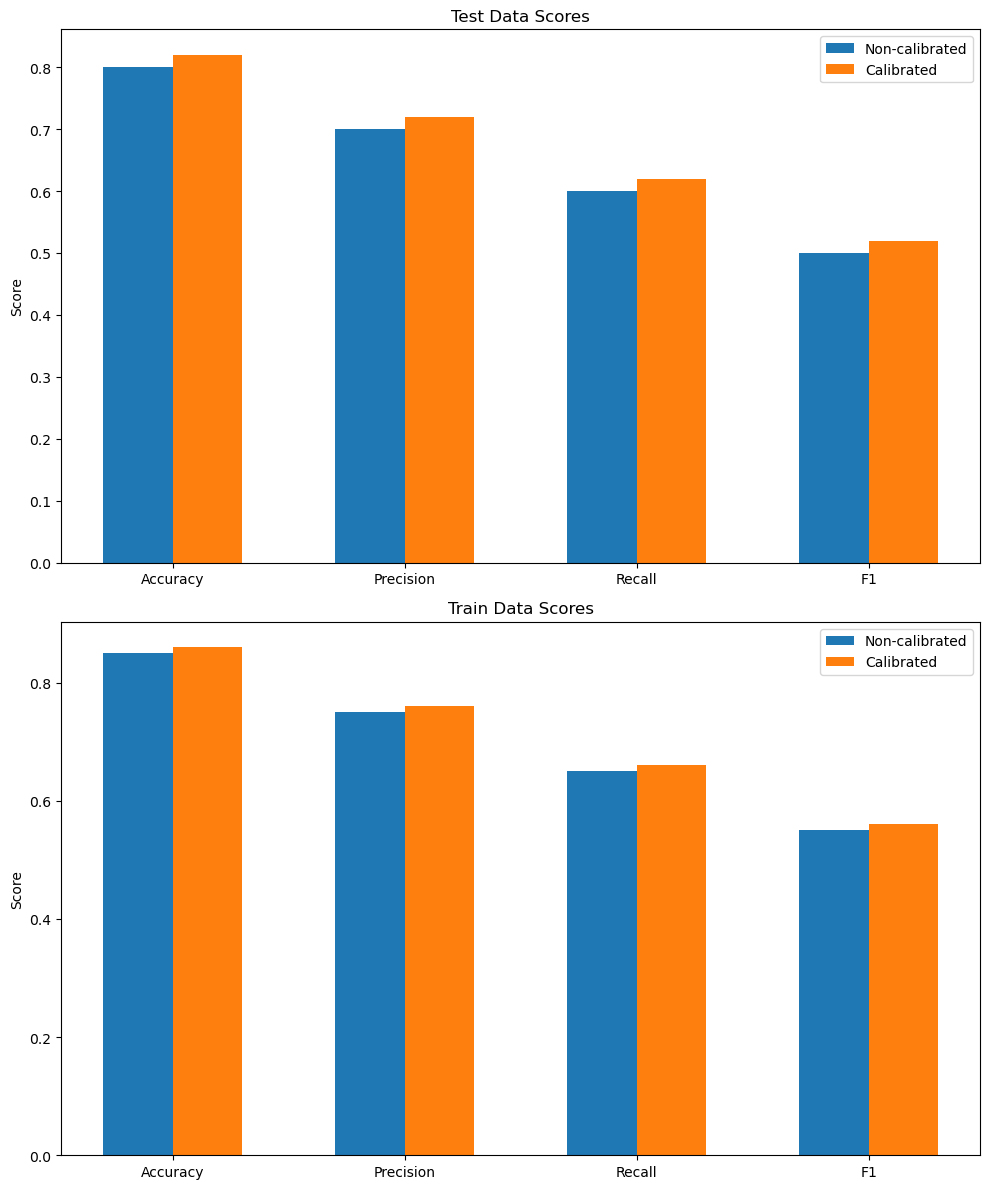

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
test_data_scores_non_calibrated = [0.8, 0.7, 0.6, 0.5]  # Replace with your actual scores
test_data_scores_calibrated = [0.82, 0.72, 0.62, 0.52]  # Replace with your actual scores
train_data_scores_non_calibrated = [0.85, 0.75, 0.65, 0.55]  # Replace with your actual scores
train_data_scores_calibrated = [0.86, 0.76, 0.66, 0.56]  # Replace with your actual scores

# Set the width of the bars
bar_width = 0.3

# Set the x locations for the groups
index = np.arange(len(test_data_scores_non_calibrated))

# Plot test data scores
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Test data scores
axes[0].bar(index - bar_width/2, test_data_scores_non_calibrated, bar_width, label='Non-calibrated')
axes[0].bar(index + bar_width/2, test_data_scores_calibrated, bar_width, label='Calibrated')
axes[0].set_title('Test Data Scores')
axes[0].set_xticks(index)
axes[0].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'])
axes[0].set_ylabel('Score')
axes[0].legend()

# Train data scores
axes[1].bar(index - bar_width/2, train_data_scores_non_calibrated, bar_width, label='Non-calibrated')
axes[1].bar(index + bar_width/2, train_data_scores_calibrated, bar_width, label='Calibrated')
axes[1].set_title('Train Data Scores')
axes[1].set_xticks(index)
axes[1].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'])
axes[1].set_ylabel('Score')
axes[1].legend()

plt.tight_layout()
plt.show()


